In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
BASE_DIR = "C:\\Users\\Siddhanth\\Internship\\data\\alzheimer\\"
TRAIN_DIR = BASE_DIR + 'train'
TEST_DIR = BASE_DIR + 'test'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [4]:
datagen = IDG(
    rescale = 1./255, 
    brightness_range=[0.8, 1.2], 
    zoom_range=[.99, 1.01], 
    data_format="channels_last", 
    fill_mode='constant',
    horizontal_flip=True
)

train_data_gen = datagen.flow_from_directory(directory=TRAIN_DIR, target_size=DIM, batch_size=5000, shuffle=False)


Found 6275 images belonging to 4 classes.


In [5]:
#retrieveing data

train_data, train_labels = train_data_gen.next()

print(train_data.shape, train_labels.shape) #Dimensions

(5000, 176, 176, 3) (5000, 4)


In [6]:
#spliting thedata into train and test

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state = 42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state = 42)

In [7]:
def conv_block(filters, act='relu'):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")

    return model

In [8]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()
CALLBACKS = [my_callback]

In [9]:
model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]



model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 176, 176, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 176, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 44, 44, 32)        14016     
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        55680     
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       221952    
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)       0 

In [10]:
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from collections import defaultdict

color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[Sequential]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

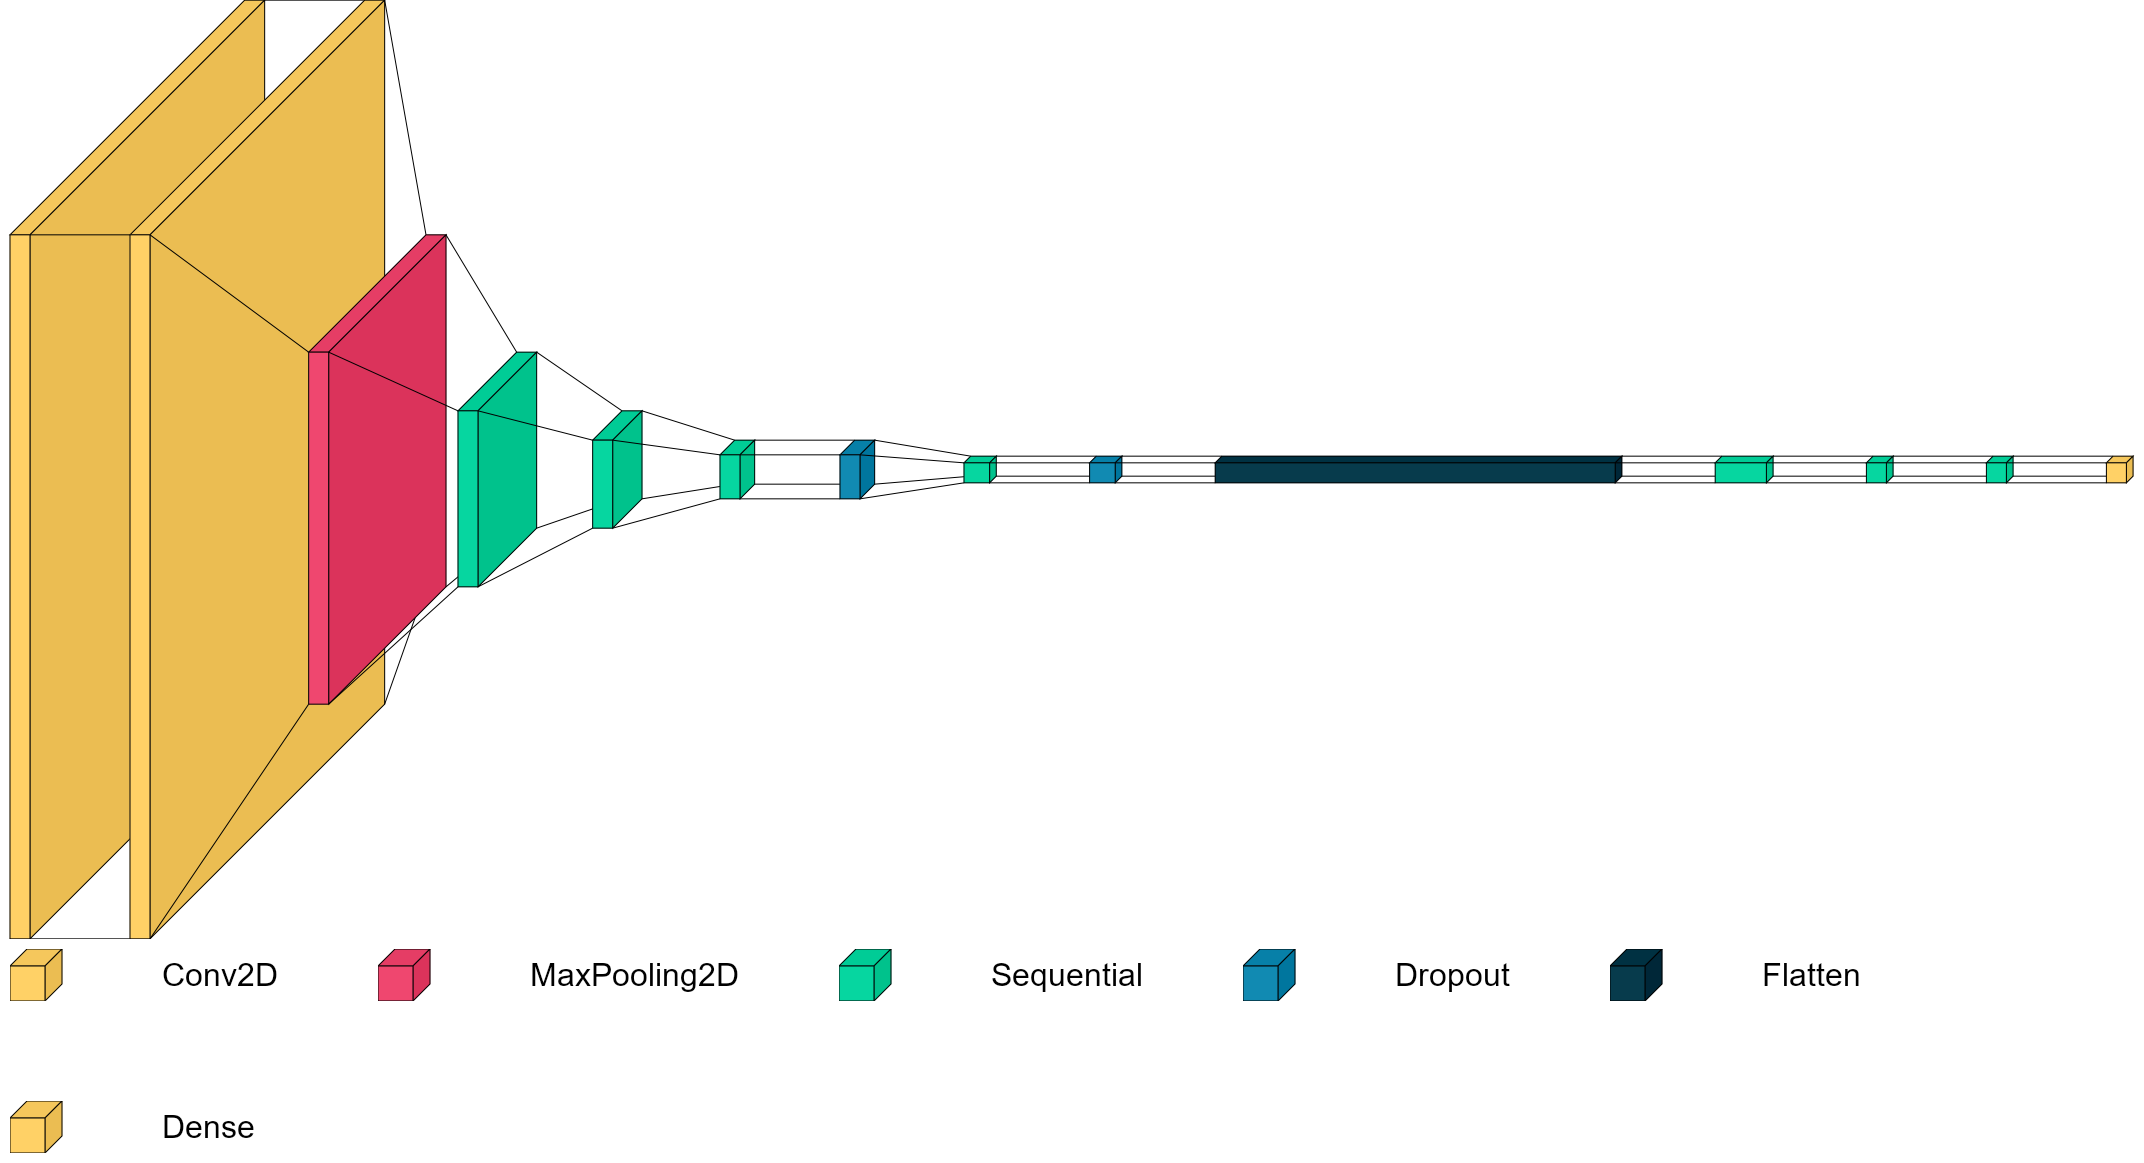

In [11]:
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)

visualkeras.layered_view(model, legend=True, font=font, spacing=100)

In [12]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 50

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)
model.save('alzheimer_model.h5')

Epoch 1/50
100/100 [==============================] - 18s 109ms/step - loss: 1.6176 - acc: 0.3494 - auc: 0.6064 - val_loss: 2.3624 - val_acc: 0.1450 - val_auc: 0.6484
Epoch 2/50
100/100 [==============================] - 10s 103ms/step - loss: 1.1580 - acc: 0.5272 - auc: 0.7692 - val_loss: 1.1320 - val_acc: 0.6525 - val_auc: 0.8114
Epoch 3/50
100/100 [==============================] - 10s 103ms/step - loss: 0.9788 - acc: 0.5962 - auc: 0.8341 - val_loss: 1.8866 - val_acc: 0.6525 - val_auc: 0.7564
Epoch 4/50
100/100 [==============================] - 10s 104ms/step - loss: 0.8891 - acc: 0.6294 - auc: 0.8644 - val_loss: 2.6867 - val_acc: 0.6525 - val_auc: 0.7764
Epoch 5/50
100/100 [==============================] - 10s 104ms/step - loss: 0.8552 - acc: 0.6494 - auc: 0.8737 - val_loss: 4.5902 - val_acc: 0.6525 - val_auc: 0.7617
Epoch 6/50
100/100 [==============================] - 10s 104ms/step - loss: 0.8175 - acc: 0.6538 - auc: 0.8835 - val_loss: 2.5648 - val_acc: 0.6388 - val_auc: 0.748

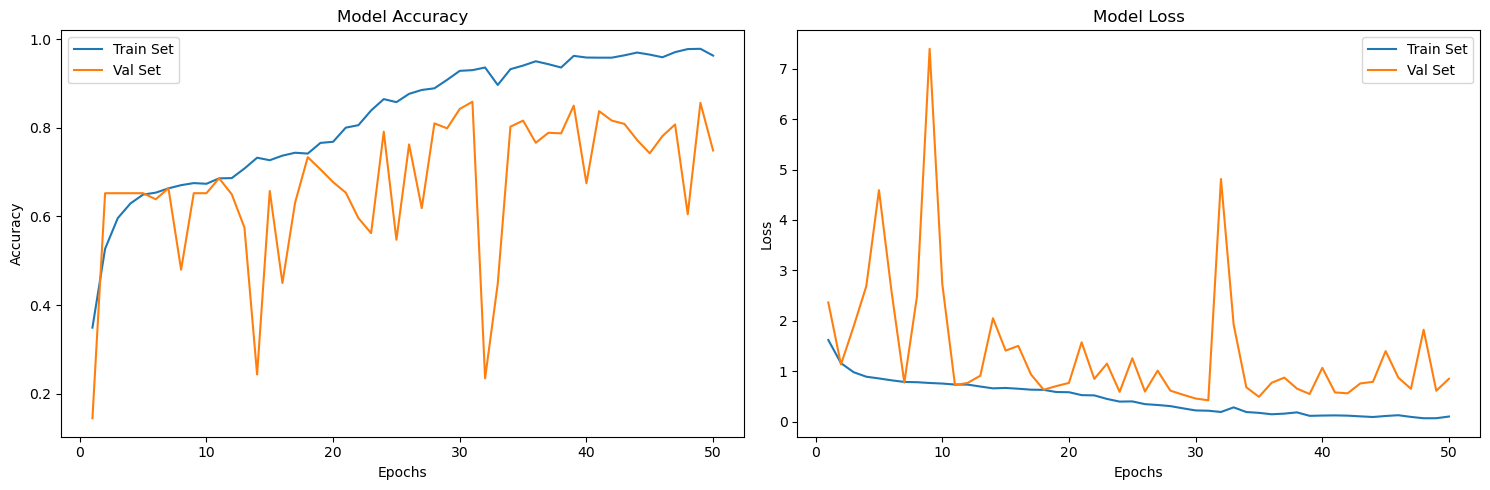

In [13]:
# plot model performance
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [14]:
#Predicting the test data

pred_labels = model.predict(test_data)

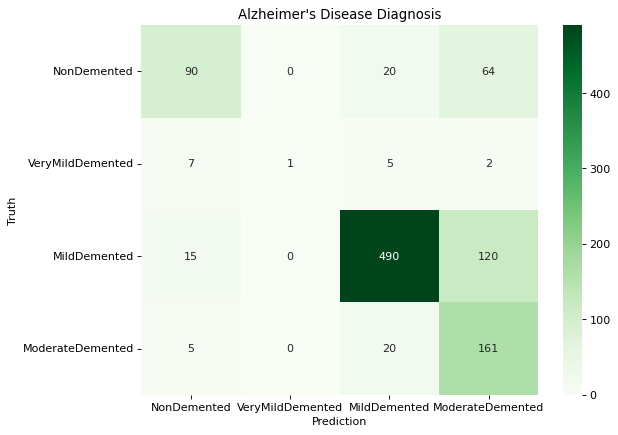

In [15]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)